In [1]:
import os

import torch
import torchvision
from torch import nn
from torchsummary import summary

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from PIL import Image
import tqdm.notebook as tqdm

from model_training_utils import CloudDetectionTrain

In [11]:
# Creating the datasets


# def get_cifar_transform(cifar_tensor):
#   data = cifar_tensor.data
#   mean = np.mean(data / 255, axis=(0,1,2))
#   std = np.std(data / 255, axis=(0,1,2))

#   transform = torchvision.transforms.Compose([
#       torchvision.transforms.ToTensor(),
#       torchvision.transforms.Normalize(mean=mean, std=std)
#   ])
#   return transform

#unnormalized_trainset = torchvision.datasets.CIFAR10(root='data', train=True,download=True, transform=torchvision.transforms.ToTensor())


#transform = get_cifar_transform(unnormalized_trainset)
# training_data = torchvision.datasets.CIFAR10(
#     root="data",
#     train=True,
#     download=True,
#     transform=transform
# )
transform = torchvision.transforms.ToTensor()
labeled_data = CloudDetectionTrain(
    transform=transform,
    pano_img_type='original'
)

batch_size = 10

proportion_train = 0.75
NUM_TRAIN = int(len(labeled_data) * proportion_train)
NUM_TRAIN = NUM_TRAIN - NUM_TRAIN % batch_size

                          
train_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(range(NUM_TRAIN))
)

val_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(range(NUM_TRAIN, len(labeled_data)))
)


In [12]:
labeled_data.dsl_df
feature_uid = labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
pano_feature_fpath = labeled_data.dataset_manager.get_pano_feature_fpath(feature_uid, 'fft')
pano_feature_fpath
labeled_data[0]

(tensor([[[130,  92,  97,  ..., 139, 176, 132],
          [124, 110,  84,  ..., 199, 182, 199],
          [ 90, 116, 128,  ..., 147, 175, 160],
          ...,
          [139, 156, 126,  ..., 141, 126, 217],
          [ 85, 173, 117,  ..., 174, 162, 172],
          [216, 218, 191,  ..., 153,  94, 183]]]),
 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


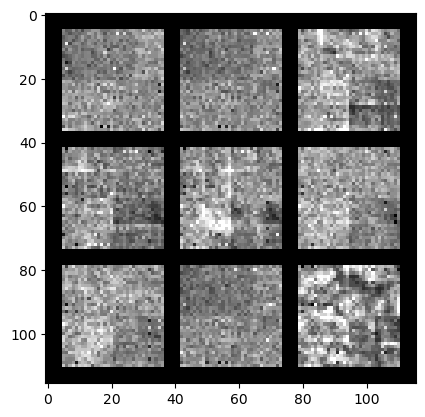

In [13]:
images = [labeled_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [14]:
# ---- Plotting ----
plt.figure(figsize=(15, 10))

def plot_loss(log, save=False):
    train_loss = log['train']['loss']
    val_loss = log['val']['loss']
    
    plt.plot(train_loss, label="training loss")
    plt.plot(val_loss, label="validation loss")
    
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.title("Cloud-Detection Training and Validation Loss vs Epoch")
    if save:
        plt.savefig("Loss")
        plt.close()

def plot_accuracy(log, save=False):
    train_acc = log['train']['acc']
    val_acc = log['val']['acc']
    
    plt.plot(train_acc, label="training accuracy")
    plt.plot(val_acc, label="validation accuracy")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    
    plt.title("Cloud-Detection Training and Validation Accuracy vs Epoch")
    if save:
        plt.savefig("Accuracy")
        plt.close()

<Figure size 1500x1000 with 0 Axes>

In [15]:
# Utils

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    else:
        "cpu"
    if verbose: print(f"Using device {device}")
    return device


def make_training_log():
    training_log = {
        'train': {
            'loss': [],
            'acc': []
        },
        'val': {
            'loss': [],
            'acc': []
        }
    }
    return training_log

In [16]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
    if isinstance(m, nn.LazyLinear):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        

def get_model_summary(dummy_model, input_shape=(3, 32, 32)):
    """Get the current model configuration."""
    dummy_loader = torch.utils.data.DataLoader(
      dataset=labeled_data,
      batch_size=1,
      sampler=torch.utils.data.SubsetRandomSampler(range(3))
    )
    dummy_model.to(device=get_device())
    dummy_model.eval()
    with torch.no_grad():
        x, y = next(iter(dummy_loader))
        x = x.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.long)
        scores = dummy_model(x)
    try:
        s = summary(dummy_model)
        with open('model_summary.txt', 'w') as f:
            f.write(str(s))
    except ValueError as verr:
        print(verr)
    finally:
        dummy_model.cpu()
        del dummy_loader

device = get_device()

In [17]:
def record_acc_and_loss(model, loss_fn, data_loader, log, data_set):
    ncorrect = 0
    nsamples = 0
    loss_total = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            loss = loss_fn(scores, y)
            loss_total += loss.item()
            
            predictions = torch.argmax(scores, dim=1)
            ncorrect += (predictions == y).sum()
            nsamples += predictions.size(0)
            
        avg_loss = loss_total / len(data_loader)
        acc = float(ncorrect) / nsamples
        
        log[data_set]['loss'].append(avg_loss)
        log[data_set]['acc'].append(acc)
        
        report = "{0}: \tloss = {1:.4f},  acc = {2}/{3} ({4:.2f}%)".format(data_set.capitalize().rjust(10), avg_loss, ncorrect, nsamples, acc * 100)
        return report
    

def train(model, optimizer, loss_fn, epochs=1):
    """
    Train the given model and report accuracy and loss during training.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: dictionary of train and validation loss and accuracy for each epoch.
    """
    # Move model to device
    model = model.to(device=device)
    
    # Init LR schedulers
    scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    scheduler_plat = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    training_log = make_training_log()
    for e in range(1, epochs + 1):
        print(f"\n\nEpoch {e}")
        for x, y in tqdm.tqdm(train_loader, unit="batches"):
            model.train()
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.long)
            
            # Forward pass: compute class scores
            scores = model(x)
            loss = loss_fn(scores, y)
            
            # Remove the gradients from the previous step
            optimizer.zero_grad() 
            
            # Backward pass: update weights
            loss.backward()
            optimizer.step()
        
        # Update log of train and validation accuracy and loss. Print progress.
        train_report = record_acc_and_loss(model, loss_fn, train_loader, training_log, 'train')
        valid_report = record_acc_and_loss(model, loss_fn, val_loader, training_log, 'val')
        print(valid_report, '\n', train_report)
        
        # Save model parameters with best validation accuracy
        val_accs = training_log['val']['acc']
        if val_accs[-1] == max(val_accs):
            torch.save(model.state_dict(), "best.pth")
         
        # Update optimizer
        scheduler_exp.step()
        scheduler_plat.step(training_log['val']['loss'][-1])
    return training_log

In [18]:
class CloudDetection(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 126, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(126),
            # nn.Dropout2d(p=0.05),

            nn.Conv2d(126, 126, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(126),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(126, 126, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(126),
            nn.Dropout2d(p=0.1),
            
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(126, 200, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(200, 200, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(200, 200, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Dropout2d(p=0.1),
            
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(200, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(256, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(256, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.2),

            nn.MaxPool2d(kernel_size=2),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(512, 512, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(512, 512, 3, stride=1, groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(p=0.3),
            
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()

        self.linear_stack = nn.Sequential(
            nn.LazyLinear(2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Dropout1d(p=0.3),
            
            nn.LazyLinear(1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Dropout1d(p=0.2),

            nn.LazyLinear(512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout1d(p=0.1),
            
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.LazyLinear(10),
        )
        #self.apply(weights_init)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)

        out = self.flatten(out)
        #print(out.shape)
        out = self.linear_stack(out)
        return out

get_model_summary(CloudDetection())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,260
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  252
|    └─Conv2d: 2-4                       143,010
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  252
|    └─Dropout2d: 2-7                    --
|    └─Conv2d: 2-8                       143,010
|    └─ReLU: 2-9                         --
|    └─BatchNorm2d: 2-10                 252
|    └─Dropout2d: 2-11                   --
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-13                      227,000
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 400
|    └─Dropout2d: 2-16                   --
|    └─Conv2d: 2-17                      360,200
|    └─ReLU: 2-18                        --
|    └─BatchNorm2d: 2-19                 400

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '




Epoch 1


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 2.2690,  acc = 0/22 (0.00%) 
      Train: 	loss = 2.2559,  acc = 0/40 (0.00%)


Epoch 2


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 2.1540,  acc = 15/22 (68.18%) 
      Train: 	loss = 2.1274,  acc = 31/40 (77.50%)


Epoch 3


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 2.2358,  acc = 15/22 (68.18%) 
      Train: 	loss = 1.3561,  acc = 31/40 (77.50%)


Epoch 4


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 3.8928,  acc = 3/22 (13.64%) 
      Train: 	loss = 2.9854,  acc = 3/40 (7.50%)


Epoch 5


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 9.2498,  acc = 1/22 (4.55%) 
      Train: 	loss = 9.8273,  acc = 6/40 (15.00%)


Epoch 6


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 6.5995,  acc = 2/22 (9.09%) 
      Train: 	loss = 6.3520,  acc = 12/40 (30.00%)


Epoch 7


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 2.4697,  acc = 10/22 (45.45%) 
      Train: 	loss = 1.9700,  acc = 20/40 (50.00%)


Epoch 8


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.5306,  acc = 17/22 (77.27%) 
      Train: 	loss = 1.1238,  acc = 34/40 (85.00%)


Epoch 9


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2422,  acc = 17/22 (77.27%) 
      Train: 	loss = 1.0089,  acc = 36/40 (90.00%)


Epoch 10


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2116,  acc = 18/22 (81.82%) 
      Train: 	loss = 1.0670,  acc = 36/40 (90.00%)


Epoch 11


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3078,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.9418,  acc = 37/40 (92.50%)


Epoch 12


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0623,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.8124,  acc = 37/40 (92.50%)


Epoch 13


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0586,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7522,  acc = 38/40 (95.00%)


Epoch 14


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0738,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.8053,  acc = 39/40 (97.50%)


Epoch 15


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0439,  acc = 19/22 (86.36%) 
      Train: 	loss = 0.7845,  acc = 39/40 (97.50%)


Epoch 16


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0889,  acc = 19/22 (86.36%) 
      Train: 	loss = 0.8082,  acc = 39/40 (97.50%)


Epoch 17


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0556,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7871,  acc = 39/40 (97.50%)


Epoch 18


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0046,  acc = 19/22 (86.36%) 
      Train: 	loss = 0.7243,  acc = 39/40 (97.50%)


Epoch 19


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0552,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7811,  acc = 39/40 (97.50%)


Epoch 20


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9936,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7385,  acc = 39/40 (97.50%)


Epoch 21


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9755,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7162,  acc = 39/40 (97.50%)


Epoch 22


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3782,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7627,  acc = 38/40 (95.00%)


Epoch 23


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2522,  acc = 20/22 (90.91%) 
      Train: 	loss = 0.7496,  acc = 38/40 (95.00%)


Epoch 24


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 2.1491,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.8240,  acc = 38/40 (95.00%)


Epoch 25


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1401,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.8579,  acc = 37/40 (92.50%)


Epoch 26


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.9276,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.8090,  acc = 38/40 (95.00%)


Epoch 27


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2765,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.8515,  acc = 38/40 (95.00%)


Epoch 28


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 2.0548,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.9347,  acc = 36/40 (90.00%)


Epoch 29


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1171,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.9093,  acc = 37/40 (92.50%)


Epoch 30


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9805,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7938,  acc = 38/40 (95.00%)


Epoch 31


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0953,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.8196,  acc = 37/40 (92.50%)


Epoch 32


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9858,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7567,  acc = 38/40 (95.00%)


Epoch 33


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1571,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7585,  acc = 38/40 (95.00%)


Epoch 34


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9955,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7028,  acc = 39/40 (97.50%)


Epoch 35


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0317,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7396,  acc = 38/40 (95.00%)


Epoch 36


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2469,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7314,  acc = 39/40 (97.50%)


Epoch 37


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9480,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7536,  acc = 37/40 (92.50%)


Epoch 38


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9619,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7585,  acc = 37/40 (92.50%)


Epoch 39


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8948,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7882,  acc = 38/40 (95.00%)


Epoch 40


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8697,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7994,  acc = 37/40 (92.50%)


Epoch 41


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3980,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7867,  acc = 38/40 (95.00%)


Epoch 42


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9173,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.8483,  acc = 38/40 (95.00%)


Epoch 43


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0536,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.9697,  acc = 37/40 (92.50%)


Epoch 44


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3369,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7517,  acc = 38/40 (95.00%)


Epoch 45


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9761,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7449,  acc = 38/40 (95.00%)


Epoch 46


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9121,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.6927,  acc = 39/40 (97.50%)


Epoch 47


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2301,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7130,  acc = 38/40 (95.00%)


Epoch 48


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2477,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7148,  acc = 37/40 (92.50%)


Epoch 49


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9006,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.6981,  acc = 38/40 (95.00%)


Epoch 50


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0044,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7620,  acc = 37/40 (92.50%)


Epoch 51


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1820,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7731,  acc = 37/40 (92.50%)


Epoch 52


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8929,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.6916,  acc = 39/40 (97.50%)


Epoch 53


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9094,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6633,  acc = 38/40 (95.00%)


Epoch 54


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2246,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7065,  acc = 38/40 (95.00%)


Epoch 55


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0022,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6909,  acc = 38/40 (95.00%)


Epoch 56


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1032,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7494,  acc = 38/40 (95.00%)


Epoch 57


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3887,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7682,  acc = 38/40 (95.00%)


Epoch 58


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9680,  acc = 16/22 (72.73%) 
      Train: 	loss = 0.7279,  acc = 39/40 (97.50%)


Epoch 59


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0758,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7042,  acc = 39/40 (97.50%)


Epoch 60


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9168,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7026,  acc = 39/40 (97.50%)


Epoch 61


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9516,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7217,  acc = 39/40 (97.50%)


Epoch 62


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.4505,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7479,  acc = 39/40 (97.50%)


Epoch 63


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0512,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7155,  acc = 39/40 (97.50%)


Epoch 64


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9728,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7400,  acc = 39/40 (97.50%)


Epoch 65


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0954,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7002,  acc = 39/40 (97.50%)


Epoch 66


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0013,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7107,  acc = 39/40 (97.50%)


Epoch 67


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8942,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7028,  acc = 39/40 (97.50%)


Epoch 68


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8770,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6762,  acc = 38/40 (95.00%)


Epoch 69


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.4570,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7350,  acc = 39/40 (97.50%)


Epoch 70


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9858,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7264,  acc = 39/40 (97.50%)


Epoch 71


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9446,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7096,  acc = 38/40 (95.00%)


Epoch 72


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2614,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6856,  acc = 39/40 (97.50%)


Epoch 73


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0423,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.6904,  acc = 39/40 (97.50%)


Epoch 74


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9027,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6845,  acc = 39/40 (97.50%)


Epoch 75


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0678,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6424,  acc = 39/40 (97.50%)


Epoch 76


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9236,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6815,  acc = 39/40 (97.50%)


Epoch 77


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9033,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.6813,  acc = 39/40 (97.50%)


Epoch 78


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3318,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6594,  acc = 39/40 (97.50%)


Epoch 79


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9786,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.6857,  acc = 39/40 (97.50%)


Epoch 80


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9577,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7367,  acc = 38/40 (95.00%)


Epoch 81


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9159,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6709,  acc = 38/40 (95.00%)


Epoch 82


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8824,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7509,  acc = 38/40 (95.00%)


Epoch 83


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2114,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7424,  acc = 38/40 (95.00%)


Epoch 84


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9975,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7316,  acc = 38/40 (95.00%)


Epoch 85


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9950,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7277,  acc = 38/40 (95.00%)


Epoch 86


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9650,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7186,  acc = 39/40 (97.50%)


Epoch 87


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.2685,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7153,  acc = 38/40 (95.00%)


Epoch 88


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.3810,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7083,  acc = 38/40 (95.00%)


Epoch 89


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.9545,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7060,  acc = 38/40 (95.00%)


Epoch 90


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1314,  acc = 16/22 (72.73%) 
      Train: 	loss = 0.6917,  acc = 39/40 (97.50%)


Epoch 91


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8470,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6776,  acc = 38/40 (95.00%)


Epoch 92


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0673,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7202,  acc = 38/40 (95.00%)


Epoch 93


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0462,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7309,  acc = 38/40 (95.00%)


Epoch 94


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8581,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6769,  acc = 38/40 (95.00%)


Epoch 95


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8512,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6958,  acc = 38/40 (95.00%)


Epoch 96


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0597,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7019,  acc = 39/40 (97.50%)


Epoch 97


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1872,  acc = 17/22 (77.27%) 
      Train: 	loss = 0.7294,  acc = 39/40 (97.50%)


Epoch 98


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.0420,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7069,  acc = 38/40 (95.00%)


Epoch 99


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 0.8921,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.6829,  acc = 39/40 (97.50%)


Epoch 100


  0%|          | 0/4 [00:00<?, ?batches/s]

       Val: 	loss = 1.1380,  acc = 18/22 (81.82%) 
      Train: 	loss = 0.7172,  acc = 39/40 (97.50%)


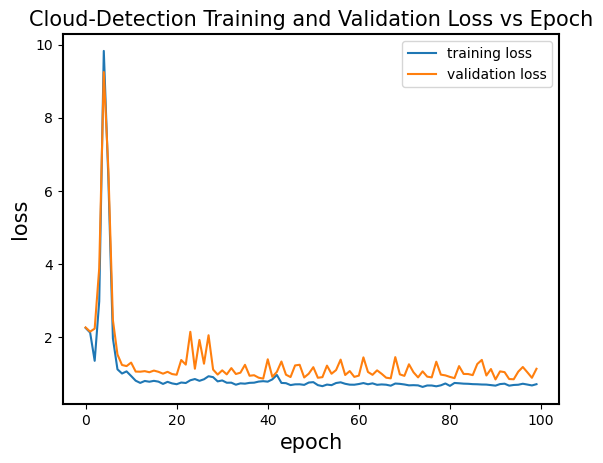

In [23]:
# Training config
learning_rate = 0.001
#momentum=0.9

model = CloudDetection()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

training_log = train(model, optimizer, loss_fn, epochs=100)

plot_loss(training_log)
#plot_accuracy(training_log)
plt.show()
plt.close()

In [13]:
# Create the test dataset
testing_data = CloudDetectionTest(
    transform=transform, # NOTE: Make sure transform is the same as the one used in the training dataset.
)

NameError: name 'CloudDetectionTest' is not defined

In [14]:
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = []
with torch.no_grad():
      model.eval() # Put model in eval mode
      for x in tqdm.tqdm(test_dataloader, unit="batch"):
          x = x.float().to(device)
          pred = model(x)
          predictions = torch.cat((predictions, torch.argmax(pred, dim=1)))
print(predictions)


NameError: name 'testing_data' is not defined

In [15]:
# Generate predictions.csv file.
import pandas as pd

predictions = predictions.cpu()

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})



NameError: name 'predictions' is not defined